In [28]:
!pip3 install torch torchvision torchaudio

In [29]:
!pip install stable-baselines3[extra] protobuf==3.20.*

In [30]:
!pip install mss pydirectinput pytesseract

In [31]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [32]:
# MSS used for screen capture
from mss import mss
# Sending commands
import pydirectinput
# Opencv allows us to do frame processing
import cv2
import numpy as np
# OCR for game over extraction
import pytesseract
# Visualize captured frames
from matplotlib import pyplot as plt
# Time for pauses
import time
# Environment components
from gym import Env
from gym.spaces import Box, Discrete

## Create Environment

In [33]:
class WebGame(Env):
    # Setup the environment and observation shapes
    def __init__(self):
        super().__init__()
        # Setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(3)
        
        # Define extraction parameters for the game
        self.cap = mss()
        self.game_location = {'top': 300, 'left': 0, 'width': 600, 'height': 500}
        self.done_location = {'top': 405, 'left': 630, 'width': 660, 'height': 70}
        
    # WHat is called to do something in the game
    def step(self, action):
        # Action key - 0=Space, 1=Duck(down), 2=No Action (no op)
        action_map = {
            0: 'space',
            1: 'down',
            2: 'no_op'
        }
        if action!=2:
            pydirectinput.press(action_map[action])
            
        #Check whether the game is done
        done, done_cap = self.get_done()
        
        # Get the next observation
        new_observation = self.get_observation()
        # Reward
        reward=1
        # Info dictionary
        info = {}
        
        return new_observation, reward, done, info
    
    # Visualize the game
    def render(self):
        cv2.imshow('Game', self.current_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
    
    # Restart the game
    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
        return self.get_observation()
    
    # This closes the observation
    def close(self):
        cv2.destroyAllWindows()
        
    # Get the part of the observation of the game that we want
    def get_observation(self):
        # Get screen capture of the game
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100,83))
        channel = np.reshape(resized, (1,83,100))
        return channel
    
    # Get the Done text using OCR
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        # Valid done text
        done_strings = ['GAME', 'GAHE']
        
        #Apply OCR
        done=False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_cap

### Test environment

In [34]:
env = WebGame()

In [35]:
obs=env.get_observation()

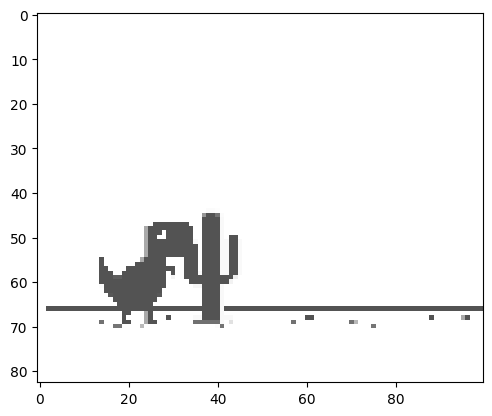

In [36]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))

In [37]:
done, done_cap = env.get_done()

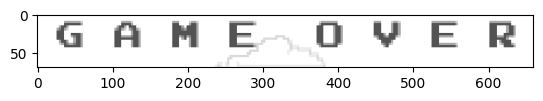

In [38]:
plt.imshow(done_cap)

In [39]:
pytesseract.image_to_string(done_cap)[:4]

'GAME'

In [40]:
for episode in range(10): 
    obs = env.reset()
    done = False  
    total_reward   = 0
    while not done: 
        obs, reward,  done, info =  env.step(env.action_space.sample())
        total_reward  += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward)) 

Total Reward for episode 0 is 11
Total Reward for episode 1 is 15
Total Reward for episode 2 is 13
Total Reward for episode 3 is 11
Total Reward for episode 4 is 11
Total Reward for episode 5 is 12
Total Reward for episode 6 is 18


### Train the model

#### Create Callback

In [ ]:
 # Import os for file path management
import os 
# Import Base Callback   for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker

c:\Users\shaur\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
env_checker.check_env(env)

In [ ]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [ ]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [ ]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

#### Build DQN and train

In [ ]:
from stable_baselines3 import DQN

In [ ]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1,
            buffer_size=120000, learning_starts=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\shaur\AppData\Local\Programs\Python\Python37\lib\site-packages\stable_baselines3\common\buffers.py:230: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 1.99GB > 1.91GB
  "This system does not have apparently enough memory to store the complete "


In [ ]:
model.learn(total_timesteps=100000, callback=callback)

KeyboardInterrupt: 

In [ ]:
model.load('train_first/best_mode l_50000')

### Test out Model

for episode in range(5): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)